In [1]:
import fitbit
import gather_keys_oauth2 as oauth2
import pandas as pd
import numpy as np
import datetime
import time
import os

import statsmodels.api as sm


f = open('settings', 'r')
settings_str = f.read()
f.close()

from ast import literal_eval
settings_dict = literal_eval(settings_str)

def date_fr_str(d):
    return datetime.datetime.date(datetime.datetime.strptime(d, '%Y-%m-%d'))
    
def date_fr_datetime(d):
    return datetime.datetime.date(d)

In [2]:
server = oauth2.OAuth2Server(settings_dict['client_id'], settings_dict['client_secret'])
server.browser_authorize()


[24/Nov/2019:14:23:52] ENGINE Listening for SIGTERM.
[24/Nov/2019:14:23:52] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[24/Nov/2019:14:23:52] ENGINE Set handler for console events.
[24/Nov/2019:14:23:52] ENGINE Started monitor thread 'Autoreloader'.
[24/Nov/2019:14:23:52] ENGINE Serving on http://127.0.0.1:8080
[24/Nov/2019:14:23:52] ENGINE Bus STARTED


127.0.0.1 - - [24/Nov/2019:14:23:54] "GET /?code=9d9852dd70c0d0cf54d033d8779a9b41f4dfc769&state=VYXapna6GdXq1kEFSwbmgqndFNAWVZ HTTP/1.1" 200 122 "" "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:70.0) Gecko/20100101 Firefox/70.0"


[24/Nov/2019:14:23:55] ENGINE Bus STOPPING
[24/Nov/2019:14:23:55] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[24/Nov/2019:14:23:55] ENGINE Removed handler for console events.
[24/Nov/2019:14:23:55] ENGINE Stopped thread 'Autoreloader'.
[24/Nov/2019:14:23:55] ENGINE Bus STOPPED
[24/Nov/2019:14:23:55] ENGINE Bus EXITING
[24/Nov/2019:14:23:55] ENGINE Waiting for child threads to terminate...
[24/Nov/2019:14:23:55] ENGINE Bus EXITED
[24/Nov/2019:14:23:55] ENGINE Waiting for thread Thread-19.


In [3]:
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(settings_dict['client_id'], settings_dict['client_secret'], oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

In [4]:

initialdate = '2017-09-20'
dateinterval = 30

In [5]:
if os.path.exists('fitbit_data.pickle'):
    dfp = pd.read_pickle('fitbit_data.pickle')
    download_start = datetime.datetime.strptime(dfp['date'].max(), '%Y-%m-%d')
    download_start = datetime.datetime.strftime(download_start, '%Y-%m-%d')
else:
    download_start = initialdate

In [6]:

startdate = datetime.datetime.strptime(download_start, '%Y-%m-%d') 
enddate = startdate + datetime.timedelta(days=dateinterval)
today = datetime.datetime.now()
days = (today-startdate).days

weight_date = []
weight_fat = []
weight_time = []
weight_weight = []



for i in range(0,days,30):
    startdate_str = datetime.datetime.strftime(startdate, '%Y-%m-%d') 
    enddate_str = datetime.datetime.strftime(enddate, '%Y-%m-%d') 
    startdate = startdate + datetime.timedelta(days=dateinterval)
    enddate = enddate + datetime.timedelta(days=dateinterval)
    fit_bodyweight = auth2_client.get_bodyweight(base_date=startdate_str, end_date=enddate_str)
    for d in fit_bodyweight['weight']:
        weight_date.append(d['date'])
        weight_fat.append(d['fat'])
        weight_time.append(d['time'])
        weight_weight.append(d['weight'])
    time.sleep(5)

In [7]:
#data downloaded from fitbit
df = pd.DataFrame({'date':weight_date,'fatpercent':weight_fat, 'weight': weight_weight})
df.head()

,date,fatpercent,weight


In [8]:
if os.path.exists('fitbit_data.pickle'):
    df = df.append(dfp)
    os.remove('fitbit_data.pickle')

In [9]:
#store the current data to a pickle for future use
df.to_pickle('fitbit_data.pickle')
df.set_index('date')
df.head()

,date,fatpercent,weight
0,2019-11-23,17.795000,165.9
1,2019-11-24,17.402000,168.4
0,2017-09-20,26.129000,190.5
1,2017-09-21,26.471001,189.8
2,2017-09-22,26.988001,190.5


In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt


In [11]:
#find where there is more than one measurement as well as days where there are no measurements

dft = df.groupby('date')['weight'].count()
pd.merge(pd.DataFrame(dft)[pd.DataFrame(dft)['weight']!=1].reset_index(), df, left_on=['date'], right_on=['date'], how='inner')

#looking at the dups it seems mostly like duplicate data has been recorded.. ie we see exactly the same wieght/fat% measurements
# only a couple days does it look like there was actually duplicate data points

,date,weight_x,fatpercent,weight_y
0,2017-09-20,2,26.129000,190.5
1,2017-09-20,2,26.129000,190.5
2,2017-09-21,2,26.471001,189.8
3,2017-09-21,2,26.471001,189.8
4,2017-09-22,2,26.988001,190.5
5,2017-09-22,2,26.988001,190.5
6,2017-09-23,2,26.716000,189.2
7,2017-09-23,2,26.716000,189.2
8,2017-09-24,2,26.679001,191.0
9,2017-09-24,2,26.679001,191.0


In [12]:
#to deal with the duplicates in date, we will average the fatpercent/wieght and group by date

dfdd = df.groupby('date')['fatpercent', 'weight'].mean()
dfdd.head()

,fatpercent,weight
date,,
2017-09-20,26.129000,190.5
2017-09-21,26.471001,189.8
2017-09-22,26.988001,190.5
2017-09-23,26.716000,189.2
2017-09-24,26.679001,191.0


In [13]:
#missing dates

#list of dates we should have
dfdt = pd.DataFrame([today - datetime.timedelta(days=x) for x in range((today - datetime.datetime.strptime(initialdate, '%Y-%m-%d')).days)])
dfdt['date']=dfdt[0].dt.date
dfdd = dfdd.reset_index()
dfdd.date = pd.to_datetime(dfdd['date'])
dfdd.date = dfdd['date'].dt.date

In [14]:
print('missing dates: ',dfdt[~dfdt.date.isin(dfdd.date)].date.count())
print('match dates: ',dfdt[dfdt.date.isin(dfdd.date)].date.count())

missing dates:  110
match dates:  685


In [15]:
dfd = pd.merge(dfdt, dfdd, left_on='date', right_on='date',how='left')[['date','fatpercent','weight']].sort_values('date',ascending=True)
dfd = dfd.reset_index()
dfd = dfd.drop(['index'], axis = 1)
dfd.head()

,date,fatpercent,weight
0,2017-09-21,26.471001,189.8
1,2017-09-22,26.988001,190.5
2,2017-09-23,26.716000,189.2
3,2017-09-24,26.679001,191.0
4,2017-09-25,26.625999,193.9


In [16]:
def row_ffill(x):
    
    #forwardfill: stepping thru the records this is the most recent non-nan value
    #errorcount: this a sequential count of nan values, it resets to zero with each non-nan value
    forwardfill = None
    errorcount = 0
    ret = []
    
    for datavalue in x:
        if ~np.isnan(datavalue):
            errorcount = 0
            forwardfill = datavalue
        else:
            datavalue = 0
            errorcount = errorcount + 1
        ret.append([datavalue, forwardfill, errorcount])
    return ret

def missing_values_fill(val):
    #run the ffill function in the forward as well as reverse directions
    fwd = row_ffill(val)
    rev = row_ffill(np.flip(val))

    #label columns and concatinate the forward and reversed record sets and concat into a dataframe

    df_rev = pd.DataFrame(np.flip(np.asarray(rev),axis=0),columns=['backdata', 'backfill', 'backnacount'])
    df_fwd = pd.DataFrame(np.asarray(fwd),columns=['forwarddata', 'forwardfill', 'forwardnacount'])
    df_calc = pd.concat([df_rev,df_fwd], axis=1)
    
    # calculate the fill value
    df_calc['totalcount']=df_calc.forwardnacount+df_calc.backnacount

    df_calc['ret'] = df_calc.forwardfill+(df_calc.backfill-df_calc.forwardfill)*\
        (df_calc.forwardnacount.div(df_calc.totalcount.where(df_calc.totalcount != 0, df_calc.backdata)))
    
    return df_calc['ret']


#### Fill Value Calculation

* forwardfill ($v_f$): this is the last non-nan value

* forwardnacount ($e_f$): this is the number of nan values there have been since the last non-nan value (including the current record)

* backfill ($v_b$): this is the next non-nan value

* backnacount ($e_b$): this is the number of nan values there are until the next non-nan value (including the current record)


$$Fill Value = v_f+(v_b-v_f)*\frac{e_f}{(e_f+e_b)}$$

In [17]:
dfd['fatper_fill'] = missing_values_fill(dfd['fatpercent'])
dfd['weight_fill'] = missing_values_fill(dfd['weight'])
dfd.head()

,date,fatpercent,weight,fatper_fill,weight_fill
0,2017-09-21,26.471001,189.8,26.471001,189.8
1,2017-09-22,26.988001,190.5,26.988001,190.5
2,2017-09-23,26.716000,189.2,26.716000,189.2
3,2017-09-24,26.679001,191.0,26.679001,191.0
4,2017-09-25,26.625999,193.9,26.625999,193.9


C:\Users\croma\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


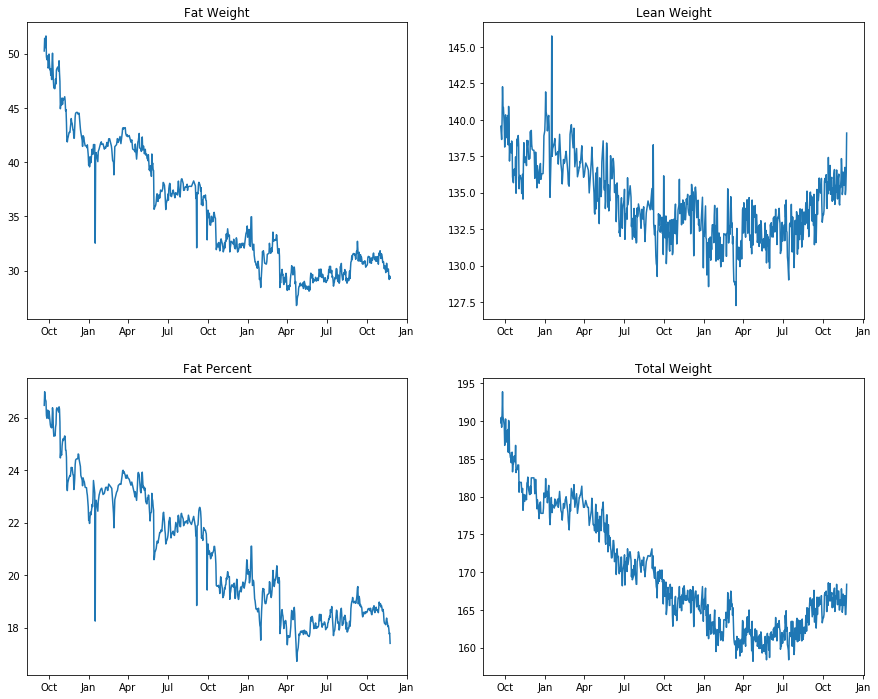

In [18]:
fig, ax = plt.subplots(2,2, figsize=(15,12))

ax[0,0].plot(pd.to_datetime(dfd['date']),dfd.fatper_fill*dfd.weight_fill/100)
ax[0,0].set(title='Fat Weight')
ax[0,0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[1,0].plot(pd.to_datetime(dfd['date']),dfd.fatper_fill)
ax[1,0].set(title='Fat Percent')
ax[1,0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[0,1].plot(pd.to_datetime(dfd['date']),dfd.weight_fill-dfd.fatper_fill*dfd.weight_fill/100)
ax[0,1].set(title='Lean Weight')
ax[0,1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[1,1].plot(pd.to_datetime(dfd['date']),dfd.weight_fill)
ax[1,1].set(title='Total Weight')
ax[1,1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

Visually we can now see that there do seem to be some outlier points, particularly with the fat measurements.  It may be that the fat percent sensor is somewhat more prone to giving a bad reading than the wieght sensor.  Will try to highlight and remove those data points.

In [19]:
dfd['fatper_fill_min_roll5_trail'] = dfd['fatper_fill'].rolling(5).min().shift(1).fillna(dfd['fatper_fill'])
dfd['fatper_fill_min_roll5_lead'] = dfd['fatper_fill'].rolling(5).min().shift(-5).fillna(dfd['fatper_fill'])

dfd['fatper_fill_max_roll5_trail'] = dfd['fatper_fill'].rolling(5).max().shift(1).fillna(dfd['fatper_fill'])
dfd['fatper_fill_max_roll5_lead'] = dfd['fatper_fill'].rolling(5).max().shift(-5).fillna(dfd['fatper_fill'])

In [20]:
dfd_outlier_low = dfd[(dfd.fatpercent < (dfd['fatper_fill_min_roll5_trail']-1)) & (dfd.fatpercent < (dfd['fatper_fill_min_roll5_lead']-1))]



In [21]:
dfd_outlier_high = dfd[(dfd.fatpercent > (dfd['fatper_fill_max_roll5_trail']+1)) & (dfd.fatpercent > (dfd['fatper_fill_max_roll5_lead']+1))]

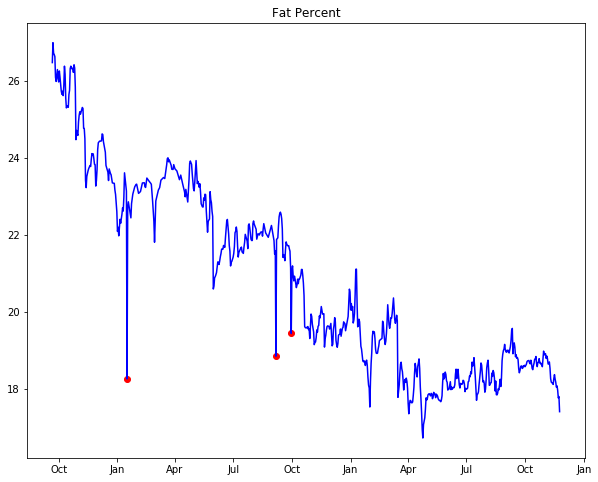

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(pd.to_datetime(dfd_outlier_low['date']),dfd_outlier_low.fatper_fill,'o', color='red')
ax.plot(pd.to_datetime(dfd_outlier_high['date']),dfd_outlier_high.fatper_fill,'o', color='red')
ax.plot(pd.to_datetime(dfd['date']),dfd.fatper_fill, color='blue')
ax.set(title='Fat Percent')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

In [23]:
dfd.loc[(dfd.fatpercent < (dfd['fatper_fill_min_roll5_trail']-1)) & (dfd.fatpercent < (dfd['fatper_fill_min_roll5_lead']-1)),'fatpercent']=np.nan

In [24]:
dfd[(dfd.fatpercent < (dfd['fatper_fill_min_roll5_trail']-1)) & (dfd.fatpercent < (dfd['fatper_fill_min_roll5_lead']-1))]

,date,fatpercent,weight,fatper_fill,weight_fill,fatper_fill_min_roll5_trail,fatper_fill_min_roll5_lead,fatper_fill_max_roll5_trail,fatper_fill_max_roll5_lead


In [25]:
dfd['fatper_fill'] = missing_values_fill(dfd['fatpercent'])

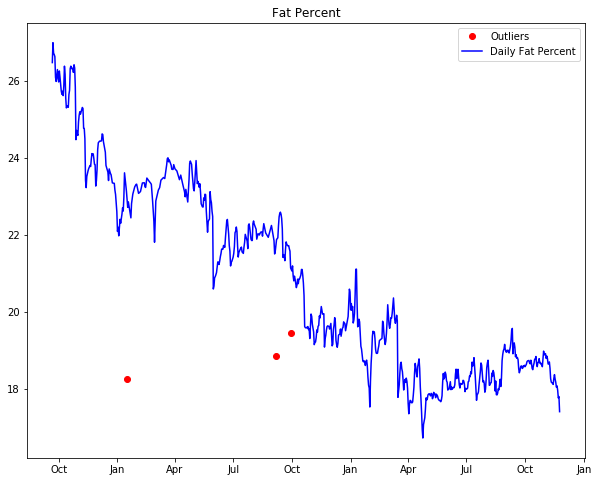

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(pd.to_datetime(dfd_outlier_low['date']),dfd_outlier_low.fatper_fill,'o', color='red')
#ax.plot(pd.to_datetime(dfd_outlier_high['date']),dfd_outlier_high.fatper_fill,'o', color='red')
ax.plot(pd.to_datetime(dfd['date']),dfd.fatper_fill, color='blue')
ax.legend(['Outliers', 'Daily Fat Percent'], loc=1)
ax.set(title='Fat Percent')
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

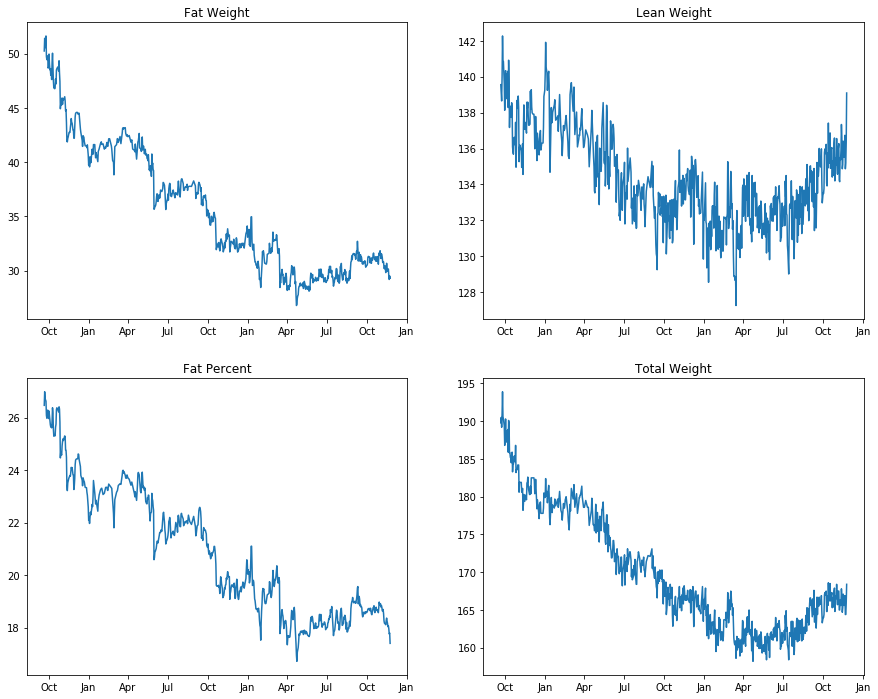

In [27]:
fig, ax = plt.subplots(2,2, figsize=(15,12))

ax[0,0].plot(pd.to_datetime(dfd['date']),dfd.fatper_fill*dfd.weight_fill/100)
ax[0,0].set(title='Fat Weight')
ax[0,0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[1,0].plot(pd.to_datetime(dfd['date']),dfd.fatper_fill)
ax[1,0].set(title='Fat Percent')
ax[1,0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[0,1].plot(pd.to_datetime(dfd['date']),dfd.weight_fill-dfd.fatper_fill*dfd.weight_fill/100)
ax[0,1].set(title='Lean Weight')
ax[0,1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[1,1].plot(pd.to_datetime(dfd['date']),dfd.weight_fill)
ax[1,1].set(title='Total Weight')
ax[1,1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

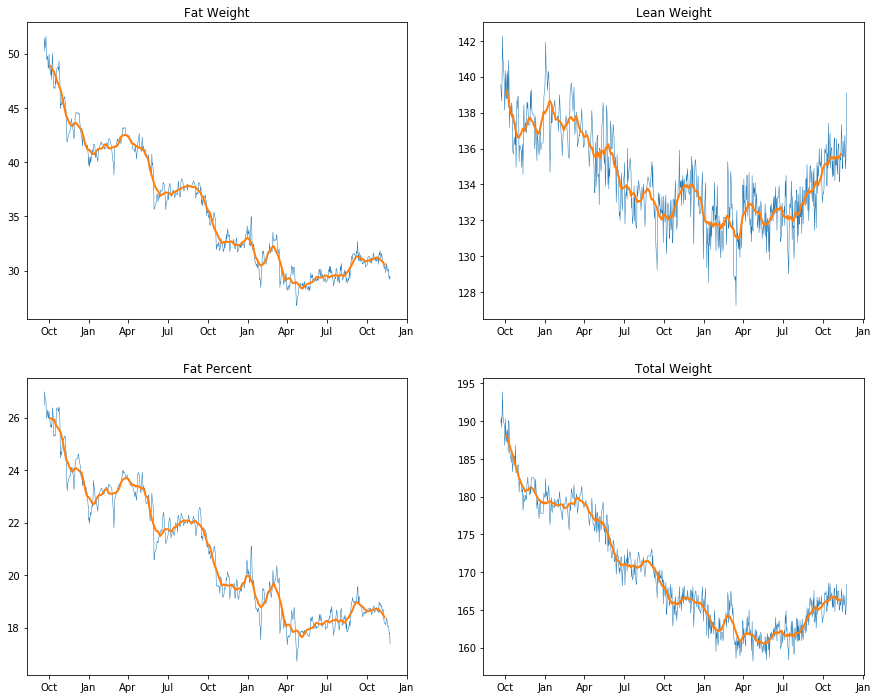

In [28]:
rolling = dfd.rolling(28, center=True)

fig, ax = plt.subplots(2,2, figsize=(15,12))

ax[0,0].plot(pd.to_datetime(dfd['date']),dfd.fatper_fill*dfd.weight_fill/100,linewidth='0.5')
ax[0,0].plot(pd.to_datetime(dfd['date']),rolling.fatper_fill.mean()*rolling.weight_fill.mean()/100,linewidth=2)
ax[0,0].set(title='Fat Weight')
ax[0,0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[1,0].plot(pd.to_datetime(dfd['date']),dfd.fatper_fill,linewidth='0.5')
ax[1,0].plot(pd.to_datetime(dfd['date']),rolling.fatper_fill.mean(),linewidth=2)
ax[1,0].set(title='Fat Percent')
ax[1,0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[0,1].plot(pd.to_datetime(dfd['date']),dfd.weight_fill-dfd.fatper_fill*dfd.weight_fill/100,linewidth='0.5')
ax[0,1].plot(pd.to_datetime(dfd['date']),rolling.weight_fill.mean()-rolling.fatper_fill.mean()*rolling.weight_fill.mean()/100,linewidth=2)
ax[0,1].set(title='Lean Weight')
ax[0,1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))
ax[1,1].plot(pd.to_datetime(dfd['date']),dfd.weight_fill,linewidth='0.5')
ax[1,1].plot(pd.to_datetime(dfd['date']),rolling.weight_fill.mean(),linewidth=2)
ax[1,1].set(title='Total Weight')
ax[1,1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%h'))

In [29]:
dfd['fat']=dfd.fatper_fill*dfd.weight_fill/100
dfd['lean']=dfd.weight_fill-dfd.fat
dfd_export = dfd[['date','weight_fill','lean','fat','fatper_fill']]
dfd_export.columns=['date','weight','lean','fat','fat_percent']

dfd_export.to_excel('export.xlsx')

#### Measuring Against Goals - Losing Fat without Losing Muscle



In [30]:
#start of analysis
start_of_analysis = '2017-09-27'
end_of_analysis = '2019-04-01'
end_of_analysis = datetime.datetime.date(datetime.datetime.strptime(end_of_analysis, '%Y-%m-%d'))

eoa_date = datetime.datetime.strptime(start_of_analysis, '%Y-%m-%d')
soa_date = eoa_date-datetime.timedelta(days=7)

soa_date = datetime.datetime.date(soa_date)
eoa_date = datetime.datetime.date(eoa_date)

In [31]:
df_bm = dfd_export

In [32]:
fat_bm = df_bm[(df_bm['date']>=soa_date) & (df_bm['date']<=eoa_date)][['fat']].mean()['fat']
lean_bm = df_bm[(df_bm['date']>=soa_date) & (df_bm['date']<=eoa_date)][['lean']].mean()['lean']
df_bm['fat_bm'] = fat_bm
df_bm['lean_bm'] = lean_bm

C:\Users\croma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\croma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [33]:
df_bm = df_bm[(df_bm['date']>=eoa_date) & (df_bm['date']<=(end_of_analysis))][['date','lean','fat','lean_bm','fat_bm']]

[Text(0.5, 1.0, 'Change from Benchmark')]

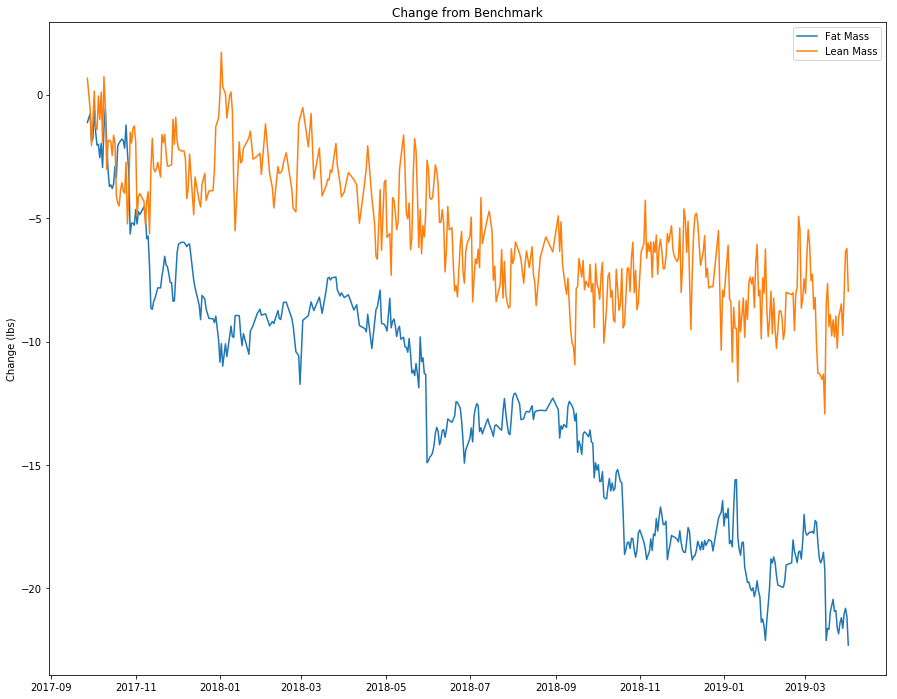

In [34]:
fig, ax = plt.subplots(figsize=(15,12))

ax.plot(pd.to_datetime(df_bm['date']),df_bm.fat-df_bm.fat_bm)
ax.plot(pd.to_datetime(df_bm['date']),df_bm.lean-df_bm.lean_bm)
ax.legend(['Fat Mass','Lean Mass'])
ax.set_ylabel('Change (lbs)')
ax.set(title='Change from Benchmark')


In [35]:
#start of analysis
start_of_analysis = '2019-04-01'
end_of_analysis = '2019-11-24'
end_of_analysis = datetime.datetime.date(datetime.datetime.strptime(end_of_analysis, '%Y-%m-%d'))

eoa_date = datetime.datetime.strptime(start_of_analysis, '%Y-%m-%d')
soa_date = eoa_date-datetime.timedelta(days=7)

soa_date = datetime.datetime.date(soa_date)
eoa_date = datetime.datetime.date(eoa_date)

In [36]:
df_bm = dfd_export
df_bm['fat_bm'] = df_bm[(df_bm['date']>=soa_date) & (df_bm['date']<=eoa_date)][['lean','fat']].mean()['fat']
df_bm['lean_bm'] = df_bm[(df_bm['date']>=soa_date) & (df_bm['date']<=eoa_date)][['lean','fat']].mean()['lean']



C:\Users\croma\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\croma\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
df_bm = df_bm[(df_bm['date']>=eoa_date) & (df_bm['date']<=(end_of_analysis))][['date','lean','fat','lean_bm','fat_bm']]
df_bm.tail()

,date,lean,fat,lean_bm,fat_bm
790,2019-11-20,136.737831,30.162169,132.120103,29.154897
791,2019-11-21,134.873762,29.526238,132.120103,29.154897
792,2019-11-22,135.204203,29.195797,132.120103,29.154897
793,2019-11-23,136.378095,29.521905,132.120103,29.154897
794,2019-11-24,139.095031,29.304969,132.120103,29.154897


[Text(0.5, 1.0, 'Change from Benchmark')]

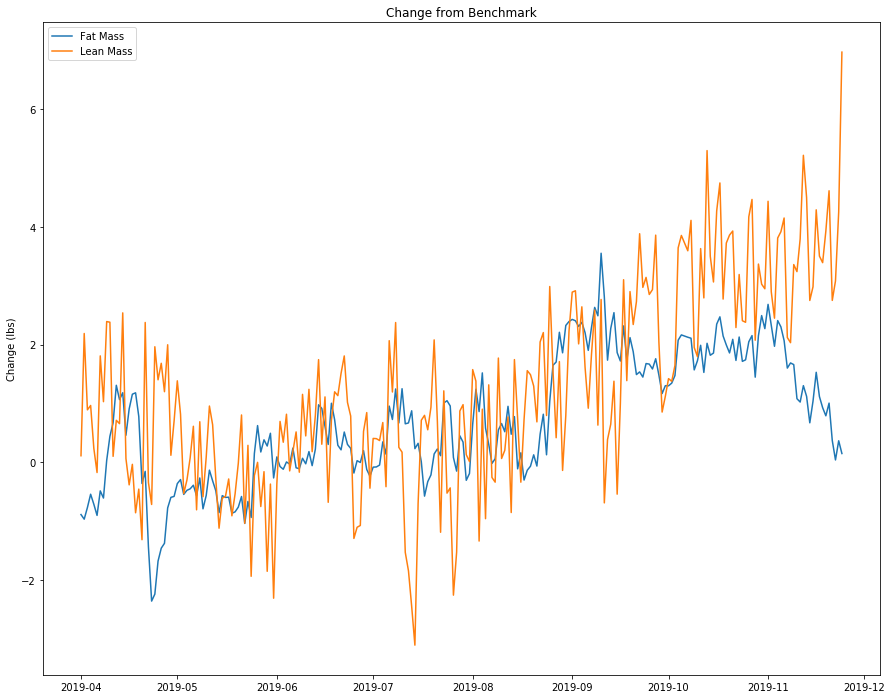

In [38]:
fig, ax = plt.subplots(figsize=(15,12))

ax.plot(pd.to_datetime(df_bm['date']),df_bm.fat-df_bm.fat_bm)
ax.plot(pd.to_datetime(df_bm['date']),df_bm.lean-df_bm.lean_bm)
ax.set_ylabel('Change (lbs)')
ax.legend(['Fat Mass','Lean Mass'])
ax.set(title='Change from Benchmark')

In [39]:
changepoints = ['2019-08-15','2019-09-01','2019-11-05']

s = df_bm.date.min()

reg_all = []
reg_sub = {}

for i in range(0,len(changepoints)+1):
    if i>len(changepoints)-1:
        e = df_bm.date.max()
    else:
        e = date_fr_str(changepoints[i])

    dts = df_bm[(df_bm['date']>=s)&(df_bm['date']<e)]['date']
    x = np.array([i for i in range(0,len(dts))])
    x = sm.add_constant(x)
    ylean = df_bm[(df_bm['date']>=s)&(df_bm['date']<e)]['lean'] - \
        df_bm[(df_bm['date']>=s)&(df_bm['date']<e)]['lean_bm']
    yfat = df_bm[(df_bm['date']>=s)&(df_bm['date']<e)]['fat'] - \
        df_bm[(df_bm['date']>=s)&(df_bm['date']<e)]['fat_bm']

    s = e
    reg_sub['dts'] = dts
    reg_sub['lean'] = sm.OLS(ylean,x).fit().fittedvalues
    reg_sub['fat'] = sm.OLS(yfat,x).fit().fittedvalues
    reg_all.append(reg_sub.copy())


[Text(0.5, 1.0, 'Change from Benchmark with Trendlines')]

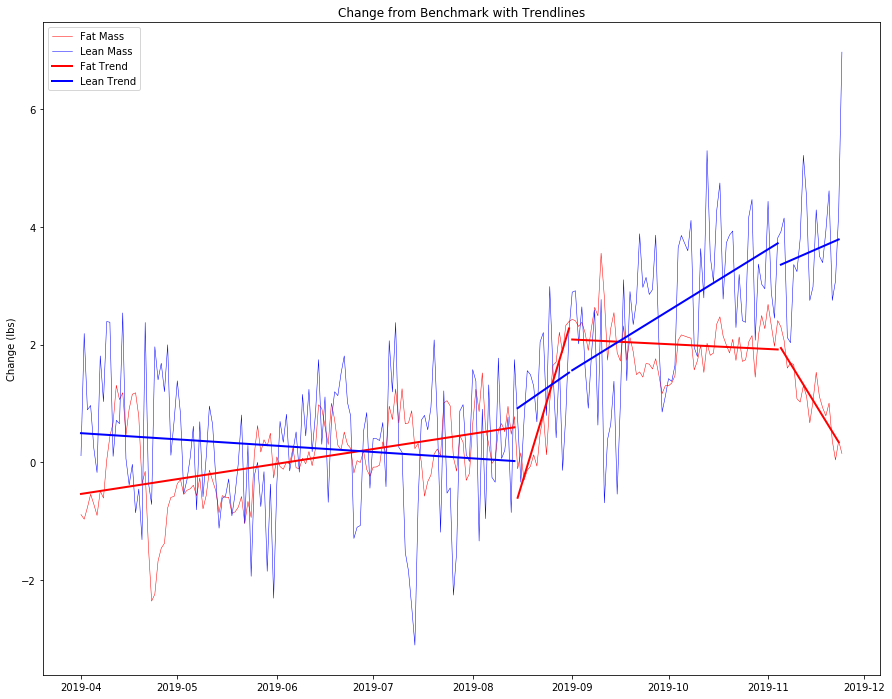

In [40]:
fig, ax = plt.subplots(figsize=(15,12))

ax.plot(pd.to_datetime(df_bm['date']),df_bm.fat-df_bm.fat_bm, color='red',linewidth=0.5)
ax.plot(pd.to_datetime(df_bm['date']),df_bm.lean-df_bm.lean_bm, color='blue',linewidth=0.5)
for i in range(0,len(reg_all)):
    ax.plot(reg_all[i]['dts'],reg_all[i]['fat'], color='red',linewidth=2)
    ax.plot(reg_all[i]['dts'],reg_all[i]['lean'], color='blue',linewidth=2)
ax.set_ylabel('Change (lbs)')
ax.legend(['Fat Mass','Lean Mass','Fat Trend','Lean Trend'])
ax.set(title='Change from Benchmark with Trendlines')

In [41]:


#CLIENT_ID = ''
#CLIENT_SECRET  = ''

#settings = {'client_id':CLIENT_ID,'client_secret':CLIENT_SECRET}
#f = open('settings','w')
#f.write(str(settings))
#f.close()

#!pip install fitbit
#!pip install wget

#there's no pip for gather_keys_oauth2.. but we can download from the github user
#url = 'https://raw.githubusercontent.com/orcasgit/python-fitbit/master/gather_keys_oauth2.py'
#wget.download(url,'C:/Users/croma/Working/Notebooks/gather_keys_oauth2.py')

#gather_keys_oauth2 needs cherrypy.. so we install that
#!pip install cherrypy